In [1]:
import numpy as np
from model_no2 import MappingBayesNet
import matplotlib.pyplot as plt
import pymc3 as pm

### Easy work with CPTs

In [1]:
from pymc3_lib import *

In [4]:
cpt = CPTCat({
'intent=0': {'object_intent=1': C(0.25)},
'intent=1': {'object_intent=0': C(0.25), 'object_intent=1': C(0.25)},
}, vars=['intent','object_intent'], n_vars=[2,2], out_n_vars=2)

cpt()

,intent,object_intent,p
0,0.0,0.0,0.25
1,1.0,0.0,0.25
2,0.0,1.0,0.00
3,1.0,1.0,0.25


Helper function for default scene

In [9]:
def load__default():
    scene_observation = {
        'A': ['grab','release'],
        'G': ['grab','release'],
        'gripper': {'range': 0.14, # [m]
                    'full': True,
        },
        'objects': {
            'cup1': { 'position': [-0.5,0.,0.],
                    'graspable': True,
                    'pushable': True,
                    'free': True,
                    'size': 0.08 # [m]
            },
            'cup2': { 'position': [0.5,0.,0.],
                    'graspable': True,
                    'pushable': True,
                    'free': True,
                    'size': 0.06
            },
        },
        'eef_position': [0.,0.,0.5],
        'gestures': [0.9, 0.1],
    }
    return scene_observation

## Model 2

Model graph

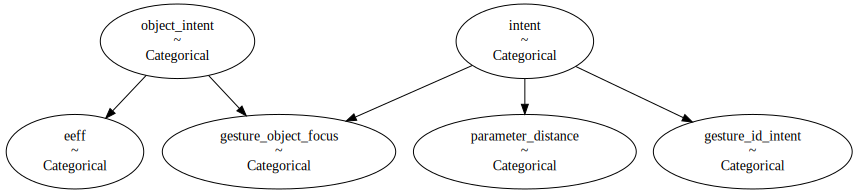

In [3]:
bn = MappingBayesNet(load__default())
bn.model()
pm.model_to_graphviz(bn.m)

### Test Gaussian
Core functions.
Parameters to customize:
- Sigma: (sigma=0.2 as default), How important are models based to distance size

Xlabel: distance [meters] Ylabel: probability [-]


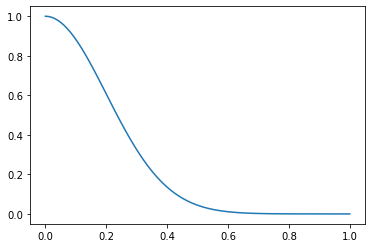

In [4]:
bn = MappingBayesNet(load__default())
x = np.linspace(0, 1, 100)
y = bn.gaussian(x).eval()
print('Xlabel: distance [meters] Ylabel: probability [-]')
plt.plot(x,y)
plt.show()

### Test sigmoid
It is a inverted sigmoid function. Parameters to customize:
- center (center=0.14 as default), feasibility breaks, e.g. p=0.5
- tau (tau=40 as default), steepness

Xlabel: distance [meters] Ylabel: probability [-]


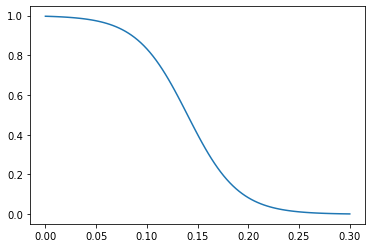

In [5]:
bn = MappingBayesNet(load__default())
x = np.linspace(0, 0.3, 100)
y = bn.sigmoid(x).eval()
print('Xlabel: distance [meters] Ylabel: probability [-]')
plt.plot(x,y)
plt.show()

### Test fea f 
Feature importance of interaction (grab) based on size of the object

Here in example, size of first object is changing (growing) and feasibility of grab is getting smaller

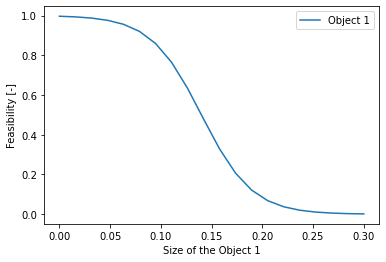

In [13]:
scene_observation = load__default()
object1 = list(scene_observation['objects'].keys())[0]
bn = MappingBayesNet(scene_observation)

sizes_test = np.linspace(0, 0.3, 20)
feaf_plot = []
for i in sizes_test:
    scene_observation['objects'][object1]['size'] = i

    sizes = [ scene_observation['objects'][obj]['size'] for obj in scene_observation['objects'].keys()]
    bn = MappingBayesNet(scene_observation)
    feaf = bn.feaf__feature().eval()
    feaf_plot.append(feaf)

feaf_plot = np.array(feaf_plot)
plt.plot(sizes_test, feaf_plot[:,0])
plt.legend(['Object 1'])
plt.xlabel("Size of the Object 1")
plt.ylabel("Feasibility [-]")
plt.show()

### Test eeff

Feature importance based on object distance to eeff (can be used also as distance to different point of interest)



eef-obj dist: [1.11803399 0.70710678], gaussian values: [3.29371411e-09 4.39369336e-02], argmax 1
eef-obj dist: [1.02956301 0.70710678], gaussian values: [7.94939362e-07 4.39369336e-02], argmax 1
eef-obj dist: [0.94339811 0.70710678], gaussian values: [5.01120029e-05 4.39369336e-02], argmax 1
eef-obj dist: [0.86023253 0.70710678], gaussian values: [0.00106477 0.04393693], argmax 1
eef-obj dist: [0.78102497 0.70710678], gaussian values: [0.00954966 0.04393693], argmax 1
eef-obj dist: [0.70710678 0.70710678], gaussian values: [0.04393693 0.04393693], argmax 0
eef-obj dist: [0.64031242 0.70710678], gaussian values: [0.12230345 0.04393693], argmax 0
eef-obj dist: [0.58309519 0.70710678], gaussian values: [0.23574608 0.04393693], argmax 0
eef-obj dist: [0.53851648 0.70710678], gaussian values: [0.3495006  0.04393693], argmax 0
eef-obj dist: [0.50990195 0.70710678], gaussian values: [0.42955736 0.04393693], argmax 0


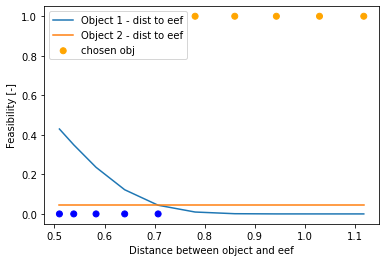

In [27]:
scene_observation = load__default()
bn = MappingBayesNet(scene_observation)

def color_coding(i):
    if i == 0:
        return 'blue'
    elif i == 1:
        return 'orange'

x = []
y = []
scatter_max = []
for i in range(-10, 0):
    scene_observation['objects']['cup1']['position'][0] = i/10
    scene_observation['objects']['cup2']['position'][0] = 0.5
    bn = MappingBayesNet(scene_observation)
    eefobjdists = np.linalg.norm(np.array(bn.object_positions__in.eval()) - np.array(bn.eef_position__in.eval()), axis=1)
    eeff = bn.eeff__feature().eval()
    x.append(eefobjdists[0])
    y.append(eeff)
    scatter_max.append(np.argmax(eeff))
    
    
eeff = np.array(eeff)
plt.plot(x, y)
plt.scatter(x, scatter_max, color=[color_coding(i) for i in scatter_max])
plt.legend(['Object 1 - dist to eef', 'Object 2 - dist to eef', 'chosen obj'])
plt.xlabel("Distance between object and eef")
plt.ylabel("Feasibility [-]")
plt.show()

### Test 1 

In [28]:
print("Test 1: cup1 object is closer")
scene_observation = load__default()
scene_observation['objects']['cup1']['position'][0] = 0.0
bn = MappingBayesNet(scene_observation)
bn.model()
print(bn.predict())

Test 1: cup1 object is closer
('release', 'cup2')


### Test 2

In [28]:
print("Test 2: cup2 object is closer")
scene_observation = load__default()
scene_observation['objects']['cup2']['position'][0] = 0.0
bn = MappingBayesNet(scene_observation)
bn.model()
print(bn.predict())

Test 2: cup2 object is closer
('grab', 'cup1')


### Test 3

In [29]:
print("Test 3: cup2 object does not fits")
scene_observation = load__default()
scene_observation['objects']['cup2']['size'] = 0.2
bn = MappingBayesNet(scene_observation)
bn.model()
print(bn.predict())

Test 3: cup2 object does not fits
('grab', 'cup1')


### Test 4 

In [30]:
print("Test 4: cup1 object does not fits")
scene_observation = load__default()
scene_observation['objects']['cup1']['size'] = 0.2
bn = MappingBayesNet(scene_observation)
bn.model()
print(bn.predict())

Test 4: cup1 object does not fits
('release', 'cup2')


### Test cup1 x coodinates

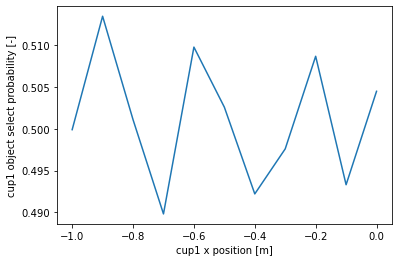

In [31]:
o1_probs = []
p_x =np.linspace(-1,0,11)
for i in p_x:
    scene_observation = load__default()
    scene_observation['objects']['cup1']['position'][0] = i
    bn = MappingBayesNet(scene_observation)
    bn.model()
    d = bn.predict(out='data')
    o1_probs.append(d[1][0])

plt.xlabel("cup1 x position [m]")
plt.ylabel("cup1 object select probability [-]")
plt.plot(p_x, o1_probs)
plt.show()

###  Test cup1 size

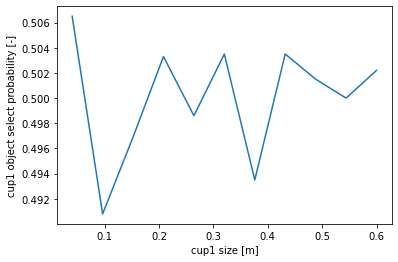

In [32]:
o1_probs = []
p_s =np.linspace(0.04,0.6,11)
for i in p_s:
    scene_observation = load__default()
    scene_observation['objects']['cup1']['size'] = i
    bn = MappingBayesNet(scene_observation)
    bn.model()
    d = bn.predict(out='data')
    o1_probs.append(d[1][0])

plt.xlabel("cup1 size [m]")
plt.ylabel("cup1 object select probability [-]")
plt.plot(p_s, o1_probs)
plt.show()

### Sample

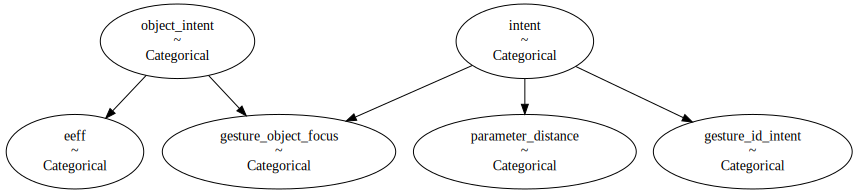

In [3]:
scene_obs = load__default()
scene_obs['gestures'] = [0.5,0.5]
scene_obs['objects']['cup2']['size'] = 0.08
bn = MappingBayesNet(scene_obs)
bn.model()
bn.predict()
pm.model_to_graphviz(bn.m)

In [30]:
scene_obs

{'A': ['grab', 'release'],
 'G': ['grab', 'release'],
 'gripper': {'range': 0.14, 'full': True},
 'objects': {'cup1': {'position': [-0.5, 0.0, 0.0],
   'graspable': True,
   'pushable': True,
   'free': True,
   'size': 0.08},
  'cup2': {'position': [0.5, 0.0, 0.0],
   'graspable': True,
   'pushable': True,
   'free': True,
   'size': 0.08}},
 'eef_position': [0.0, 0.0, 0.5],
 'gestures': [0.5, 0.5]}

In [33]:
predict_samples = []
for i in range(50):
    predict_samples.append(bn.predict())

In [4]:
bn.info

intent ~ Categorical
P: [0.5, 0.5]
object_intent ~ Categorical
P: [0.5, 0.5]
gesture_id_intent ~ Categorical
CPT: [[0.5 0. ]
 [0.  0.5]]
parameter_distance ~ Categorical
P switch: [[0.5 0. ]
 [0.  0.5]]
gesture_object_focus ~ Categorical
CPT: [[[0.75 0.25]
  [0.75 0.25]]

 [[0.75 0.25]
  [0.75 0.25]]]
eeff ~ Categorical
P switch: [0.04393693 0.04393693]


(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],


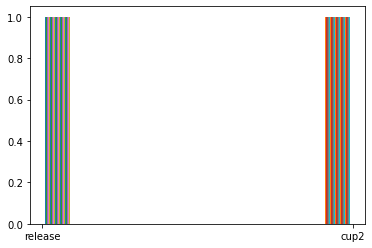

In [49]:
plt.hist(predict_samples)

# Model 2.1
In this model, refining the parameters

In [7]:
from model_no2_1 import MappingBayesNet
from pymc3_lib import *

import matplotlib.pyplot as plt

In [8]:
probabilities = {}
probabilities['cpt_gesture_object_focus'] = CPTCat({
'intent=0': {'object_intent=0': C(0.25), 'object_intent=1': C(0.25)},
'intent=1': {'object_intent=0': C(0.25), 'object_intent=1': C(0.25)},
})
probabilities['mt_parameter_distance'] = CPTCat({
'intent=0': [0.2, 0.3, 0.5],
'intent=1': [0.7, 0.2, 0.1],
})
def load__default():
    scene_observation = {
        'A': ['grab','release'],
        'G': ['grab','release'],
        'gestures': [0.9, 0.1],
        'robot': {'gripper_range': 0.14, # [m]
                  'gripper_full': True,
                  'eef_position': [0.,0.,0.5]
        },
        'objects': {
            'cup1': { 'position': [-0.5,0.,0.],
                    'graspable': True,
                    'pushable': True,
                    'free': True,
                    'size': 0.08 # [m]
            },
            'cup2': { 'position': [0.5,0.,0.],
                    'graspable': True,
                    'pushable': True,
                    'free': True,
                    'size': 0.06
            },
        },
    }
    return scene_observation
scene = load__default()

In [3]:
bn = MappingBayesNet(scene, probabilities=probabilities)

In [4]:
bn.mt_gestures.eval()

array([[0.9, 0. ],
       [0. , 0.1]])

In [5]:
scene['gestures']

[0.9, 0.1]

In [6]:
bn.model()

In [8]:
priors = bn.sample()

(array([52., 48.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)

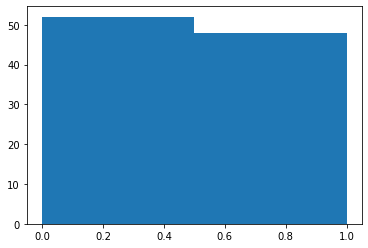

In [23]:
plt.hist(priors['intent'],2)

(array([49., 51.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)

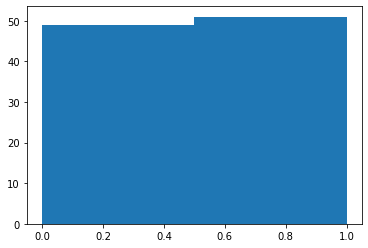

In [16]:
plt.hist(priors['object_intent'],2)

In [18]:
priors.keys()

dict_keys(['intent', 'object_intent', 'eeff', 'feaf', 'gesture_object_focus', 'parameter_distance', 'gesture_id_intent'])

(array([98.,  2.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)

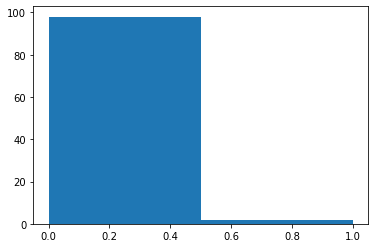

In [21]:
plt.hist(priors['eeff'],2)

(array([ 5., 95.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)

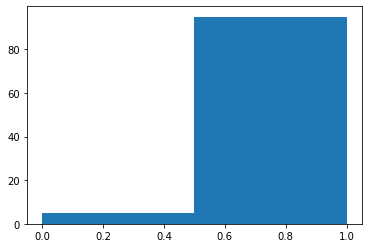

In [22]:
plt.hist(priors['feaf'],2)

In [9]:
from submodules.Scenes import Scene

In [10]:
s1 = Scene(init='cup,cup')

In [12]:
scene = s1.to_dict()
scene['A'] = ['grab','release']
scene['G'] = ['grab','release']
scene['gestures'] = [0.9, 0.1]

In [13]:
bn = MappingBayesNet(scene, probabilities=probabilities)

In [15]:
bn.model()

In [16]:
bn.sample()

{'parameter_distance': array([0, 0, 1, 2, 0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 2, 2, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2,
        0, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 2]),
 'eeff': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'feaf': array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

**Description:**
For this scene state, the 